Finetuning an ImageNet-pretrained model here makes no sense, because the data is very different and too simple. So, this is just to show how to do it.

In [1]:
! pip install opencv-python

In [2]:
import torch
from torchvision import models, datasets, transforms
from torcheval.metrics import MulticlassAccuracy
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = "cpu"
device = torch.device(dev)
device

device(type='cpu')

In [4]:
# transform = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
transform = transforms.Compose([transforms.ToTensor()])
mnist_pytorch = datasets.MNIST(root='./data/test', train=False, download=True, transform=transform)

In [5]:
mnist_pytorch.data.shape

torch.Size([10000, 28, 28])

resize to ImageNet image sizes (training data set for AlexNet)

In [6]:
X = mnist_pytorch.data.numpy().astype('uint8')

# initialize new array for colored and resized images
X_resized = np.zeros((X.shape[0], 224, 224, 3), dtype=np.uint8)

# resize each image
for i in range(len(X)):
    X_resized[i] = cv2.resize(cv2.cvtColor(X[i], cv2.COLOR_GRAY2RGB), (224, 224), interpolation=cv2.INTER_CUBIC)

X = X_resized
X.shape

(10000, 224, 224, 3)

normalize based on images from ImageNet

In [7]:
X = (X / 255 - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179039301310043..2.6399999999999997].


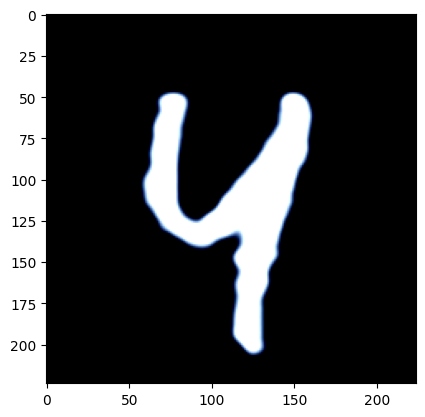

In [8]:
plt.imshow(X[42], cmap='gray')

In [9]:
target_tensor = torch.nn.functional.one_hot(mnist_pytorch.targets).to(dtype=torch.float32).to(device)

different order of dimensions

In [10]:
input_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

In [11]:
input_ds = torch.utils.data.TensorDataset(input_tensor, target_tensor)

In [12]:
train_ds, test_ds = torch.utils.data.random_split(input_ds, [0.8, 0.2])
train_ds, val_ds = torch.utils.data.random_split(train_ds, [0.9, 0.1])

In [13]:
mini_batch_size = 512

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=mini_batch_size, shuffle=True, drop_last=False)
valid_dl = torch.utils.data.DataLoader(val_ds, batch_size=mini_batch_size * 2)

In [14]:
model = models.alexnet()

just feature extraction, no finetuning

In [15]:
for param in model.parameters():  # Freeze parameters so we don't update them
    param.requires_grad = False

In [16]:
new_layers = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=9216, out_features=4096, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(p=0.5, inplace=False),
    torch.nn.Linear(in_features=4096, out_features=1000, bias=True),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(in_features=1000, out_features=10, bias=True),
)

model.classifier = new_layers

model = model.to(device)

In [17]:
optimizer = torch.optim.Adam(model.parameters())

In [18]:
def fit(epochs, model, optimizer, train_dl, valid_dl=None):
    loss_func = torch.nn.CrossEntropyLoss()

    # loop over epochs
    for epoch in range(epochs):
        model.train()

        # loop over mini-batches
        for X_mb, y_mb in train_dl:
            y_hat = model(X_mb)

            loss = loss_func(y_hat, y_mb)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            train_loss = sum(loss_func(model(X_mb), y_mb) for X_mb, y_mb in train_dl)
            valid_loss = sum(loss_func(model(X_mb), y_mb) for X_mb, y_mb in valid_dl)
        print('epoch {}, training loss {}'.format(epoch + 1, train_loss / len(train_dl)))
        print('epoch {}, validation loss {}'.format(epoch + 1, valid_loss / len(valid_dl)))

    print('Finished training')

    return model

In [19]:
epochs = 10

trained_model = fit(epochs, model, optimizer, train_dl, valid_dl)

epoch 1, training loss 1.5625137090682983
epoch 1, validation loss 1.5481371879577637
epoch 2, training loss 0.6124348044395447
epoch 2, validation loss 0.5883775949478149
epoch 3, training loss 0.45563188195228577
epoch 3, validation loss 0.4250415563583374
epoch 4, training loss 0.30767738819122314
epoch 4, validation loss 0.3041236102581024
epoch 5, training loss 0.21337834000587463
epoch 5, validation loss 0.21875335276126862
epoch 6, training loss 0.22989794611930847
epoch 6, validation loss 0.21721559762954712
epoch 7, training loss 0.20742827653884888
epoch 7, validation loss 0.21421614289283752
epoch 8, training loss 0.18284989893436432
epoch 8, validation loss 0.20600709319114685
epoch 9, training loss 0.19238071143627167
epoch 9, validation loss 0.21484777331352234
epoch 10, training loss 0.1704390048980713
epoch 10, validation loss 0.17684507369995117
Finished training


In [20]:
def evaluation(ds, model):
    with torch.no_grad():
        preds = model(ds[:][0]).cpu()

    # take output node with highest probability
    yhat = np.argmax(preds, axis=1)
    y = ds[:][1].cpu()

    # from one-hot back to labels
    y = torch.argmax(y, dim=1)

    metric = MulticlassAccuracy()

    metric.update(yhat, y)
    return metric.compute()

In [21]:
# evaluation(train_ds, trained_model)

In [22]:
evaluation(test_ds, trained_model)

tensor(0.9425)